Import all necessary dependencies:

In [48]:
from qutip import basis, tensor, destroy, qeye, sigmax, sigmaz, mesolve, expect as q_expect
import numpy as np
import matplotlib.pyplot as plt


Parameters

In [49]:
# --- Parameters ---
N = 3
t_total = 10
tlist1 = np.linspace(0, t_total/2, 250)
tlist2 = np.linspace(t_total/2, t_total, 250)

g = [0.0, 1.0, 0.0]     # Only qubit 1 is driven
J = [0.1, 0.1]          # Crosstalk between qubits 0–1 and 1–2
Delta = [0.0, 0.0, 0.0] # No detuning

Operators

In [50]:
# --- Operators ---
sm_list, sz_list, sx_list = [], [], []
for i in range(N):
    op_list = [qeye(2) for _ in range(N)]
    op_list[i] = destroy(2)
    sm_list.append(tensor(op_list))

    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))

    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))


Hamiltonian Operations

In [51]:

# --- Hamiltonian ---
H = 0
for i in range(N):
    H += g[i] * (sm_list[i] + sm_list[i].dag())      # Rabi on qubit 1
    H += 0.5 * Delta[i] * sz_list[i]                 # Detuning

# Nearest-neighbor crosstalk
H += J[0] * sx_list[0] * sx_list[1]
H += J[1] * sx_list[1] * sx_list[2]


Linblad Terms

In [52]:
# --- Collapse Operators ---
c_ops = []
for i in range(N):
    if T1[i] > 0.0:
        c_ops.append(np.sqrt(1.0 / T1[i]) * sm_list[i])  # Amplitude damping
    if T2[i] > 0.0:
        gamma_phi = 1.0 / T2[i] - 0.5 / T1[i]            # Pure dephasing rate
        if gamma_phi > 0:
            c_ops.append(np.sqrt(gamma_phi) * sz_list[i])

Solve

In [53]:
# --- Initial state: |111⟩ ---
psi0 = tensor([basis(2, 1) for _ in range(N)])

# --- Measurement operators ---
e_ops = [sm.dag() * sm for sm in sm_list]  # Proj |1><1|

# --- First evolution (before π pulse) ---
result1 = mesolve(H, psi0, tlist1, [], [])
psi_after_first_half = result1.states[-1]

# --- Central π pulse on qubit 1 ---
U_pi_center = (-1j * np.pi * sx_list[1] / 2).expm()
psi_after_center = U_pi_center * psi_after_first_half

# --- Echo π pulses on qubits 0 and 2 ---
U_echo = (-1j * np.pi * sx_list[0] / 2).expm() * (-1j * np.pi * sx_list[2] / 2).expm()
psi_after_echo = U_echo * psi_after_center

# --- Second evolution ---
result2 = mesolve(H, psi_after_echo, tlist2, [], e_ops)

# --- Compute expectations from first half manually ---
expect1 = [[q_expect(op, state) for state in result1.states] for op in e_ops]

# --- Combine time and expectation values ---
tlist = np.concatenate([tlist1, tlist2])
expect_values = [np.concatenate([expect1[i], result2.expect[i]]) for i in range(N)]

Plot Results

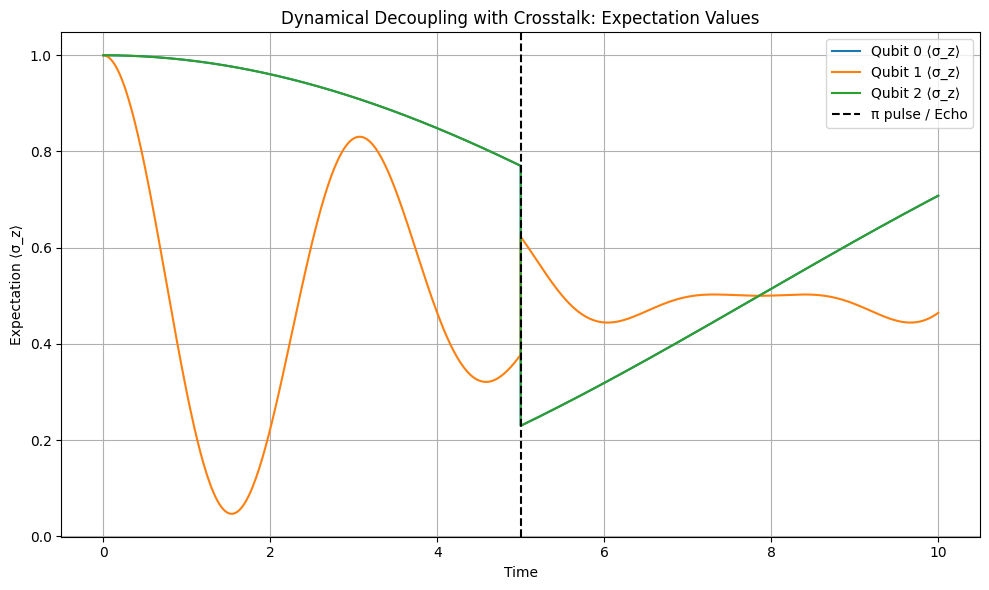

In [56]:
# --- Compute expectations for first half manually ---
expect1 = [[q_expect(op, state) for state in result1.states] for op in e_ops]

# --- Extract expectations from second half automatically ---
expect2 = result2.expect  # mesolve used e_ops for second half

# --- Combine time and expectations ---
tlist = np.concatenate([tlist1, tlist2])
expect_total = [np.concatenate([e1, e2]) for e1, e2 in zip(expect1, expect2)]

# --- Plotting ---
labels = ['Qubit 0 ⟨σ_z⟩', 'Qubit 1 ⟨σ_z⟩', 'Qubit 2 ⟨σ_z⟩']

plt.figure(figsize=(10, 6))
for i, exp in enumerate(expect_total):
    plt.plot(tlist, exp, label=labels[i])
plt.axvline(tlist1[-1], color='k', linestyle='--', label='π pulse / Echo')
plt.xlabel('Time')
plt.ylabel('Expectation ⟨σ_z⟩')
plt.title('Dynamical Decoupling with Crosstalk: Expectation Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()